# 特征有效性验证实验

验证5类特征在异常检测中的有效性：
1. **平均数特征** - 均值差异
2. **曲线模式特征** - 突变/趋势/尖峰
3. **波动性特征** - 变异系数/波动聚集
4. **分布特征** - 偏度/峰度
5. **平滑度特征** - 二阶导数

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys
sys.path.append('/home/ubuntu/smore/aiops2025')
from exp.agent.enhanced_metric_analyzer import CurveFeatureExtractor
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (16, 10)
print('✓ Setup complete')

✓ Setup complete


In [2]:
def gen_normal(n=200,m=100,s=5,seed=None):
    if seed: np.random.seed(seed)
    return np.random.normal(m,s,n)+np.linspace(0,2,n)+3*np.sin(np.linspace(0,4*np.pi,n))

def gen_spike(n=200,m=100,s=5,seed=None):
    d=gen_normal(n,m,s,seed)
    d[100:105]+=50
    return d

def gen_shift(n=200,m=100,s=5,seed=None):
    d=gen_normal(n,m,s,seed)
    d[100:]+=40
    return d

def gen_trend(n=200,m=100,s=5,seed=None):
    if seed: np.random.seed(seed)
    d=np.random.normal(m,s,n)
    d[:100]+=np.linspace(0,30,100)
    d[100:]+=30-np.linspace(0,40,100)
    return d

def gen_volatile(n=200,m=100,s=5,seed=None):
    d=gen_normal(n,m,s,seed)
    d[100:]+=25*np.sin(np.linspace(0,10*np.pi,100))
    return d

n_samples=30
data={'Normal':[gen_normal(seed=i) for i in range(n_samples)],
      'Spike':[gen_spike(seed=i) for i in range(n_samples)],
      'Level Shift':[gen_shift(seed=i) for i in range(n_samples)],
      'Trend Change':[gen_trend(seed=i) for i in range(n_samples)],
      'High Volatility':[gen_volatile(seed=i) for i in range(n_samples)]}
print(f'Generated {len(data)} types, {n_samples} samples each')

Generated 5 types, 30 samples each


## 对比：正常 vs 异常 (带标注)

==================== 新特征 (Tsfresh) 验证 ====================

📍 [Normal] Tsfresh Features:
   - sum_values: 20269.17
   - median: 101.58
   - mean: 101.35
   - standard_deviation: 5.14
   - maximum: 114.60
   - minimum: 84.96

📍 [Spike] Tsfresh Features:
   - sum_values: 20400.53
   - median: 100.99
   - mean: 102.00
   - standard_deviation: 10.03
   - maximum: 157.44
   - minimum: 86.29

📍 [Level Shift] Tsfresh Features:
   - sum_values: 24150.53
   - median: 122.66
   - mean: 120.75
   - standard_deviation: 21.76
   - maximum: 158.55
   - minimum: 86.29

📍 [Trend Change] Tsfresh Features:
   - sum_values: 22450.53
   - median: 112.95
   - mean: 112.25
   - standard_deviation: 11.94
   - maximum: 142.47
   - minimum: 88.56

📍 [High Volatility] Tsfresh Features:
   - sum_values: 20150.53
   - median: 100.24
   - mean: 100.75
   - standard_deviation: 12.93
   - maximum: 130.41
   - minimum: 72.42


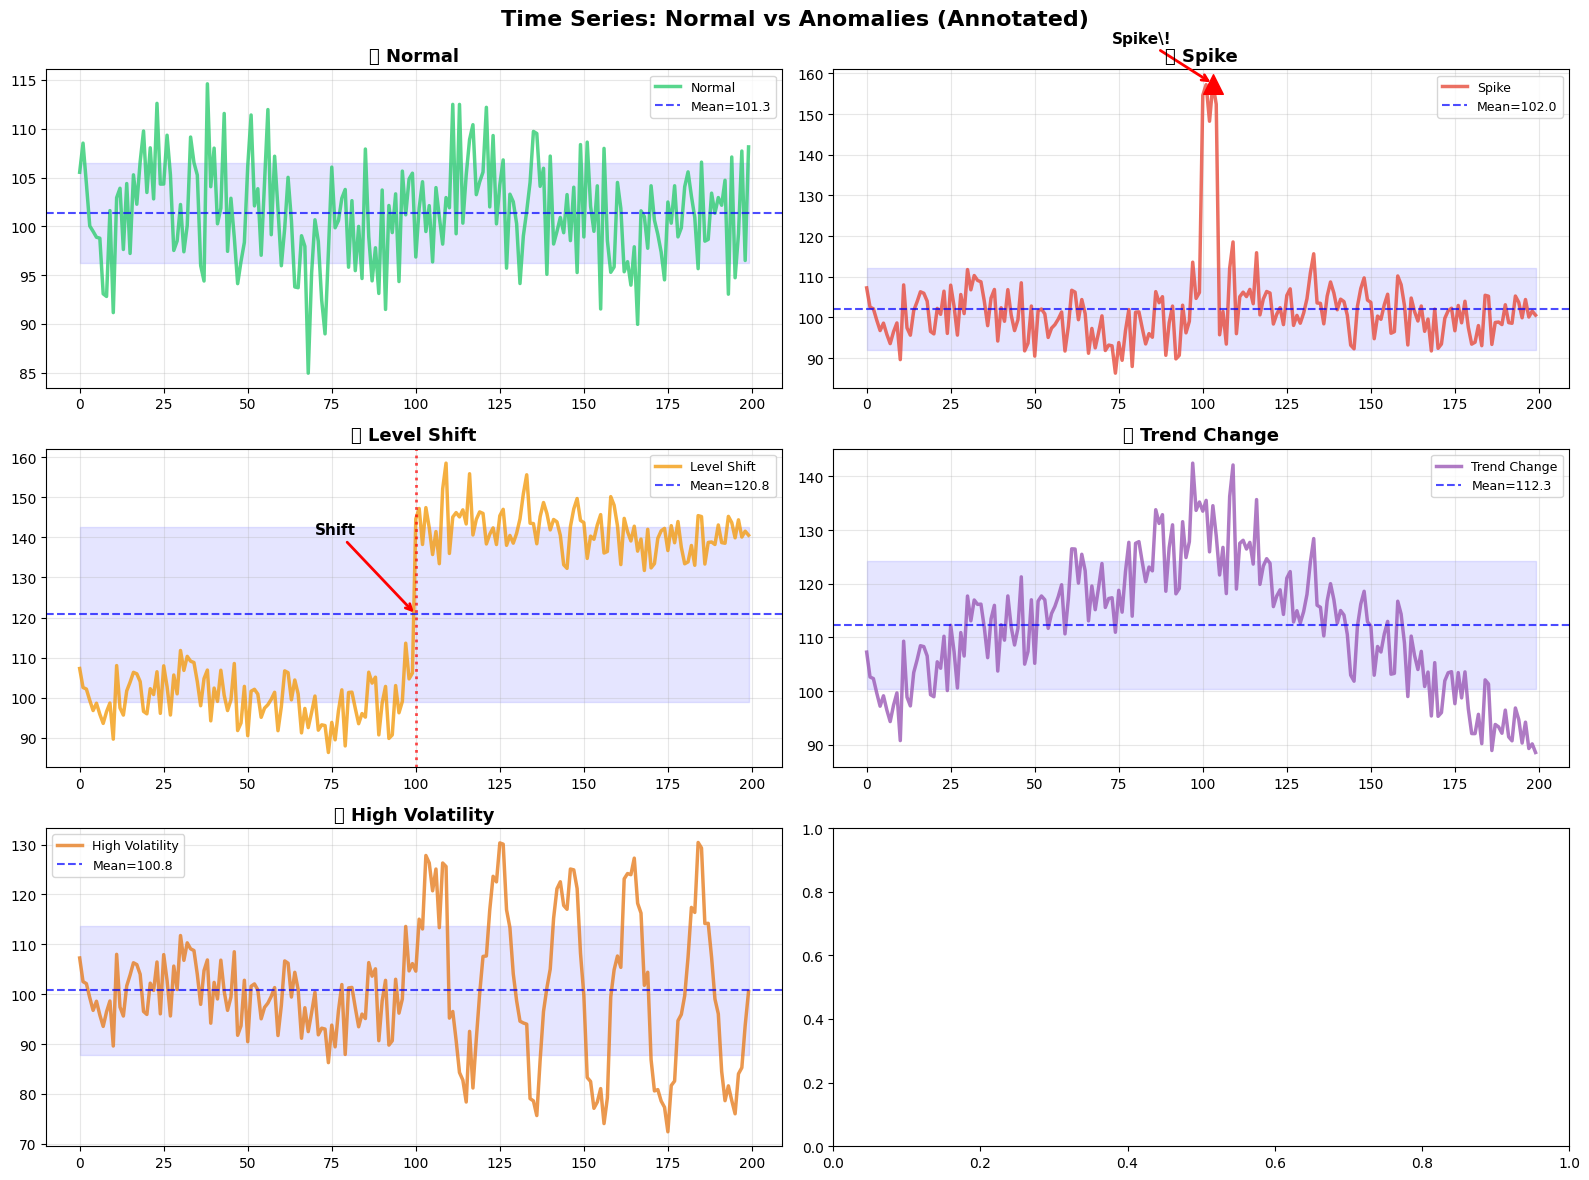

In [ ]:
fig,axes=plt.subplots(3,2,figsize=(16,12))
fig.suptitle('Time Series: Normal vs Anomalies (Annotated)',fontsize=16,fontweight='bold')
colors={'Normal':'#2ecc71','Spike':'#e74c3c','Level Shift':'#f39c12','Trend Change':'#9b59b6','High Volatility':'#e67e22'}

# Initialize extractor for verification
# Reload module to ensure we have the latest updates
import importlib
import exp.agent.enhanced_metric_analyzer as ema
importlib.reload(ema)
ext = ema.CurveFeatureExtractor()

print(f"{'='*20} 新特征 (Tsfresh) 验证 {'='*20}")

for idx,(name,samples) in enumerate(data.items()):
    ax=axes[idx//2,idx%2]
    s=samples[0]
    
    # Plotting
    ax.plot(s,lw=2.5,color=colors[name],alpha=0.8,label=name)
    m,std=np.mean(s),np.std(s)
    ax.axhline(m,color='blue',ls='--',lw=1.5,alpha=0.7,label=f'Mean={m:.1f}')
    ax.fill_between(range(len(s)),m-std,m+std,color='blue',alpha=0.1)
    
    if name=='Spike':
        idx_spike=np.argmax(s)
        ax.scatter([idx_spike],[s[idx_spike]],color='red',s=200,marker='^',zorder=5)
        ax.annotate('Spike\!',xy=(idx_spike,s[idx_spike]),xytext=(idx_spike-30,s[idx_spike]+10),arrowprops=dict(arrowstyle='->',lw=2,color='red'),fontsize=11,fontweight='bold')
    elif name=='Level Shift':
        ax.axvline(100,color='red',ls=':',lw=2,alpha=0.7)
        ax.annotate('Shift',xy=(100,m),xytext=(70,m+20),arrowprops=dict(arrowstyle='->',lw=2,color='red'),fontsize=11,fontweight='bold')
    ax.set_title(f'🔍 {name}',fontsize=13,fontweight='bold')
    ax.legend(loc='best',fontsize=9)
    ax.grid(True,alpha=0.3)
    
    # Verify new features
    try:
        ts_feats = ext.extract_tsfresh_features(pd.Series(s))
        print(f"[{name}] Tsfresh Features:")
        # Select some representative features to display
        display_keys = ['sum_values', 'median', 'mean', 'standard_deviation', 'maximum', 'minimum']
        for k in display_keys:
            if k in ts_feats:
                print(f"   - {k}: {ts_feats[k]:.2f}")
    except Exception as e:
        print(f"   Error extracting features: {e}")

plt.tight_layout()
plt.show()

## 特征提取

In [4]:
ext=CurveFeatureExtractor(min_change_threshold=0.2)
def extract_features(sample):
    s=pd.Series(sample)
    sc=ext.detect_sudden_changes(s)
    tc=ext.detect_trend_changes(s)
    sd=ext.detect_spikes_and_dips(s)
    tv=ext.detect_threshold_violations(s,{})
    stat=ext.extract_statistical_features(s)
    return {'mean':stat.get('mean',0),'std':stat.get('std',0),'cv':stat.get('cv',0),
            'skewness':stat.get('skewness',0),'kurtosis':stat.get('kurtosis',0),
            'smoothness':stat.get('smoothness',0),'volatility_clustering':stat.get('volatility_clustering',0),
            'sudden_changes':len(sc),'trend_changes':len(tc),'spikes':len([x for x in sd if x['type']=='spike']),
            'total_patterns':len(sc)+len(tc)+len(sd)}

all_f=[]
for name,samples in data.items():
    for i,s in enumerate(samples):
        f=extract_features(s)
        f['type']=name
        all_f.append(f)
df=pd.DataFrame(all_f)
print(f'✓ Extracted {len(df)} samples with {len(df.columns)-1} features')
print(df.groupby('type').mean().round(2))

✓ Extracted 150 samples with 11 features
                   mean    std    cv  skewness  kurtosis  smoothness  \
type                                                                   
High Volatility  101.02  13.46  0.13      0.10      0.01        0.09   
Level Shift      121.02  21.19  0.18     -0.00     -1.77        0.09   
Normal           101.04   5.36  0.05     -0.02      0.14        0.09   
Spike            102.27   9.56  0.09      3.42     16.32        0.09   
Trend Change     112.52  11.79  0.10     -0.13     -0.63        0.09   

                 volatility_clustering  sudden_changes  trend_changes  spikes  \
type                                                                            
High Volatility                   5.48            3.70          32.70    3.63   
Level Shift                       3.25            2.97          45.13    0.00   
Normal                            1.20            1.40          46.90    4.57   
Spike                             5.25           

## 特征对比表

In [5]:
print('='*100)
print('特征对比：正常 vs 异常')
print('='*100)
comp=df.groupby('type').agg(['mean','std']).round(3)
print(comp)
print('\n'+'='*100)
print('与正常类型的差异百分比')
print('='*100)
norm_vals=df[df['type']=='Normal'].mean(numeric_only=True)
for atype in ['Spike','Level Shift','Trend Change','High Volatility']:
    anom_vals=df[df['type']==atype].mean(numeric_only=True)
    diff=((anom_vals-norm_vals)/(norm_vals+1e-10)*100).round(1)
    print(f'\n{atype}:')
    print(diff[['mean','cv','smoothness','total_patterns']])

特征对比：正常 vs 异常
                    mean            std            cv        skewness         \
                    mean    std    mean    std   mean    std     mean    std   
type                                                                           
High Volatility  101.016  0.391  13.457  0.406  0.133  0.004    0.101  0.110   
Level Shift      121.016  0.391  21.191  0.360  0.175  0.003   -0.005  0.021   
Normal           101.036  0.392   5.360  0.269  0.053  0.003   -0.019  0.132   
Spike            102.266  0.391   9.564  0.346  0.094  0.003    3.417  0.189   
Trend Change     112.516  0.391  11.786  0.289  0.105  0.003   -0.128  0.104   

                kurtosis         ... volatility_clustering         \
                    mean    std  ...                  mean    std   
type                             ...                                
High Volatility    0.014  0.155  ...                 5.475  0.340   
Level Shift       -1.765  0.025  ...                 3.253  0.198   


## 特征可视化

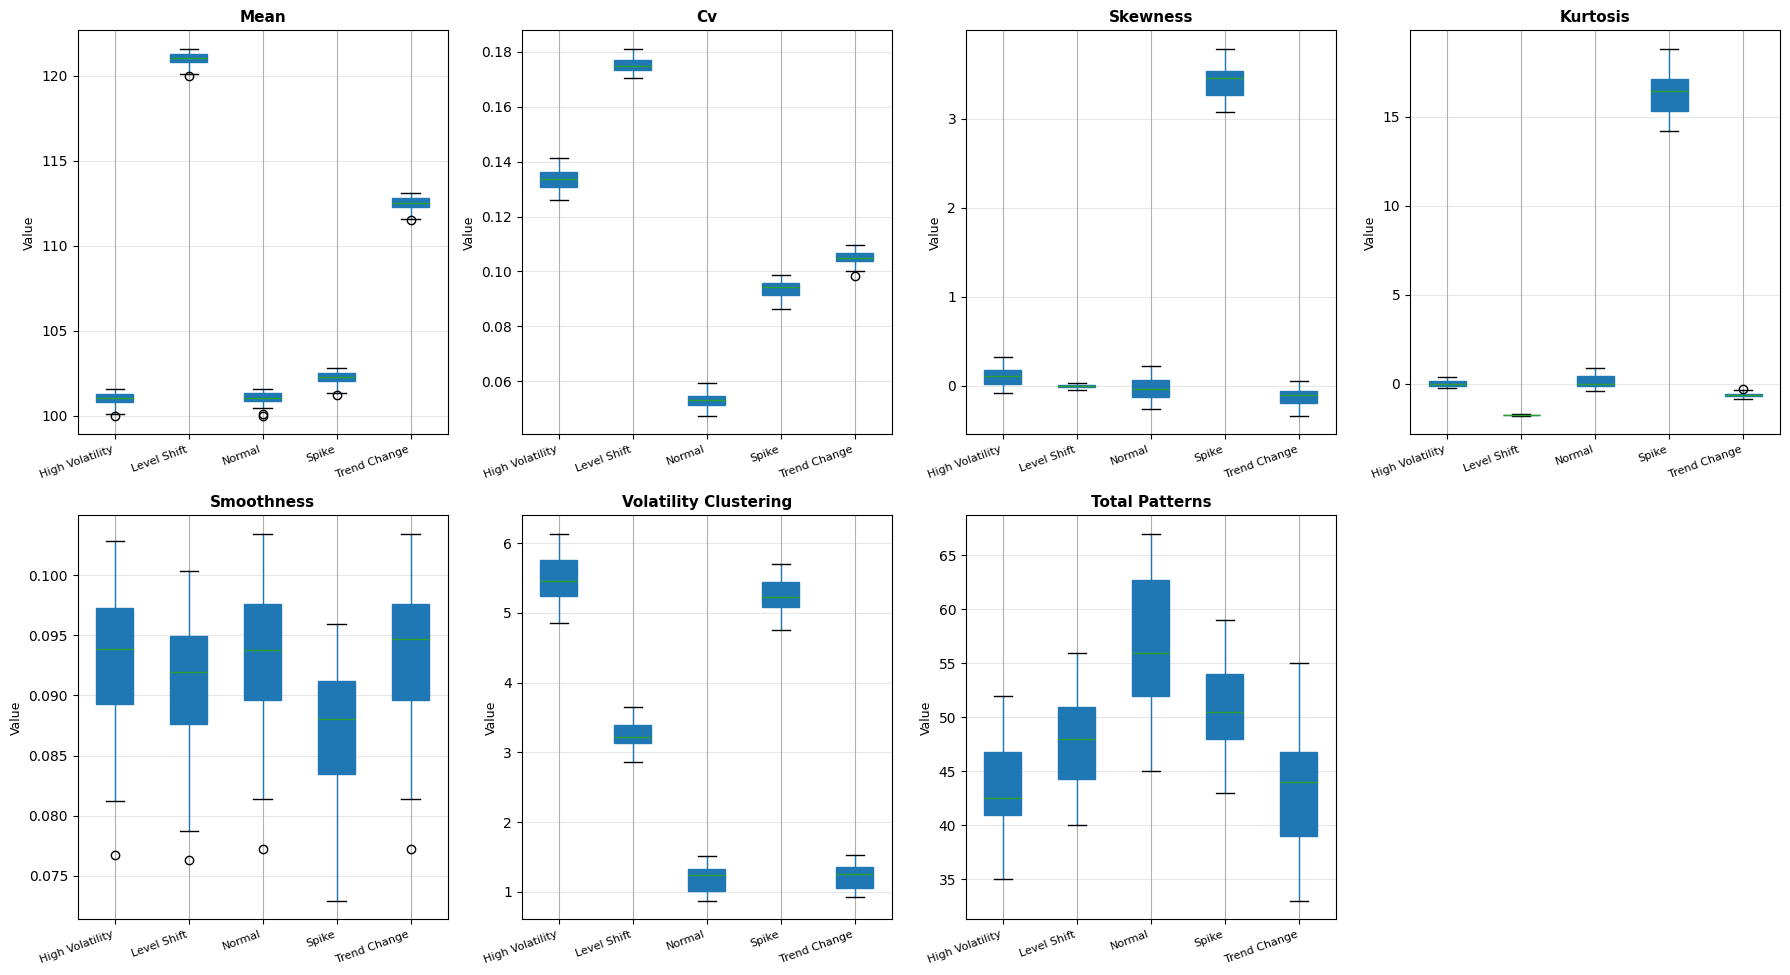

✓ 观察：异常类型在多个特征维度上与正常类型有明显差异


In [6]:
fig,axes=plt.subplots(2,4,figsize=(18,10))
fig.suptitle('Key Features: Normal vs Anomalies',fontsize=16,fontweight='bold')
key_features=['mean','cv','skewness','kurtosis','smoothness','volatility_clustering','total_patterns']
type_order=['Normal','Spike','Level Shift','Trend Change','High Volatility']
for idx,feat in enumerate(key_features):
    ax=axes[idx//4,idx%4]
    df.boxplot(column=feat,by='type',ax=ax,patch_artist=True)
    ax.set_title(f'{feat.replace("_"," ").title()}',fontsize=11,fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Value',fontsize=9)
    ax.get_figure().suptitle('')
    plt.setp(ax.xaxis.get_majorticklabels(),rotation=20,ha='right',fontsize=8)
    ax.grid(True,alpha=0.3,axis='y')
axes[1,3].axis('off')
plt.tight_layout()
plt.show()
print('✓ 观察：异常类型在多个特征维度上与正常类型有明显差异')

## 统计显著性检验 (T-test)

In [7]:
print('='*110)
print('T-TEST: Normal vs Each Anomaly Type')
print('='*110)
test_features=['mean','cv','smoothness','volatility_clustering','total_patterns']
norm_data=df[df['type']=='Normal']
results=[]
for atype in ['Spike','Level Shift','Trend Change','High Volatility']:
    anom_data=df[df['type']==atype]
    for feat in test_features:
        t_stat,p_val=stats.ttest_ind(norm_data[feat],anom_data[feat])
        eff_size=(anom_data[feat].mean()-norm_data[feat].mean())/norm_data[feat].std()
        sig='✓✓✓' if p_val<0.001 else ('✓✓' if p_val<0.01 else ('✓' if p_val<0.05 else '✗'))
        results.append({'Type':atype,'Feature':feat,'p-value':f'{p_val:.2e}','Effect':f'{eff_size:.2f}','Sig':sig})
res_df=pd.DataFrame(results)
print(res_df.to_string(index=False))
print('='*110)
print('\n说明: ✓✓✓=p<0.001(极显著) | ✓✓=p<0.01(非常显著) | ✓=p<0.05(显著) | ✗=不显著')
print('Effect Size: >0.8=大 | 0.5-0.8=中 | 0.2-0.5=小')

T-TEST: Normal vs Each Anomaly Type
           Type               Feature  p-value Effect Sig
          Spike                  mean 1.28e-17   3.14 ✓✓✓
          Spike                    cv 3.75e-50  14.90 ✓✓✓
          Spike            smoothness 1.59e-04  -0.99 ✓✓✓
          Spike volatility_clustering 2.58e-58  22.03 ✓✓✓
          Spike        total_patterns 1.29e-04  -0.92 ✓✓✓
    Level Shift                  mean 9.15e-84  50.99 ✓✓✓
    Level Shift                    cv 1.19e-79  44.94 ✓✓✓
    Level Shift            smoothness 1.73e-01  -0.35   ✗
    Level Shift volatility_clustering 6.89e-45  11.17 ✓✓✓
    Level Shift        total_patterns 8.10e-08  -1.41 ✓✓✓
   Trend Change                  mean 7.62e-70  29.30 ✓✓✓
   Trend Change                    cv 3.25e-59  19.04 ✓✓✓
   Trend Change            smoothness 9.00e-01   0.03   ✗
   Trend Change volatility_clustering 5.42e-01   0.15   ✗
   Trend Change        total_patterns 4.22e-12  -2.19 ✓✓✓
High Volatility                  mea

## 特征热力图

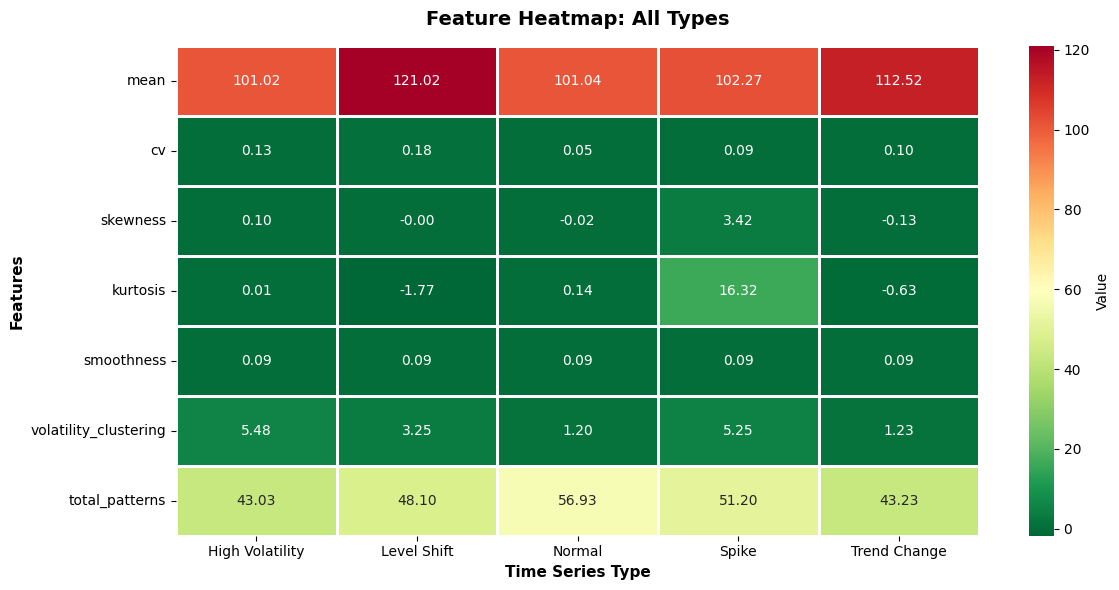

✓ 颜色越深表示值越高
✓ 可以清晰看到不同异常类型的特征模式


In [8]:
fig,ax=plt.subplots(figsize=(12,6))
heat_data=df.groupby('type')[key_features].mean().T
sns.heatmap(heat_data,annot=True,fmt='.2f',cmap='RdYlGn_r',cbar_kws={'label':'Value'},linewidths=1,ax=ax)
ax.set_title('Feature Heatmap: All Types',fontsize=14,fontweight='bold',pad=15)
ax.set_ylabel('Features',fontsize=11,fontweight='bold')
ax.set_xlabel('Time Series Type',fontsize=11,fontweight='bold')
plt.tight_layout()
plt.show()
print('✓ 颜色越深表示值越高')
print('✓ 可以清晰看到不同异常类型的特征模式')

## 二维特征空间：区分能力

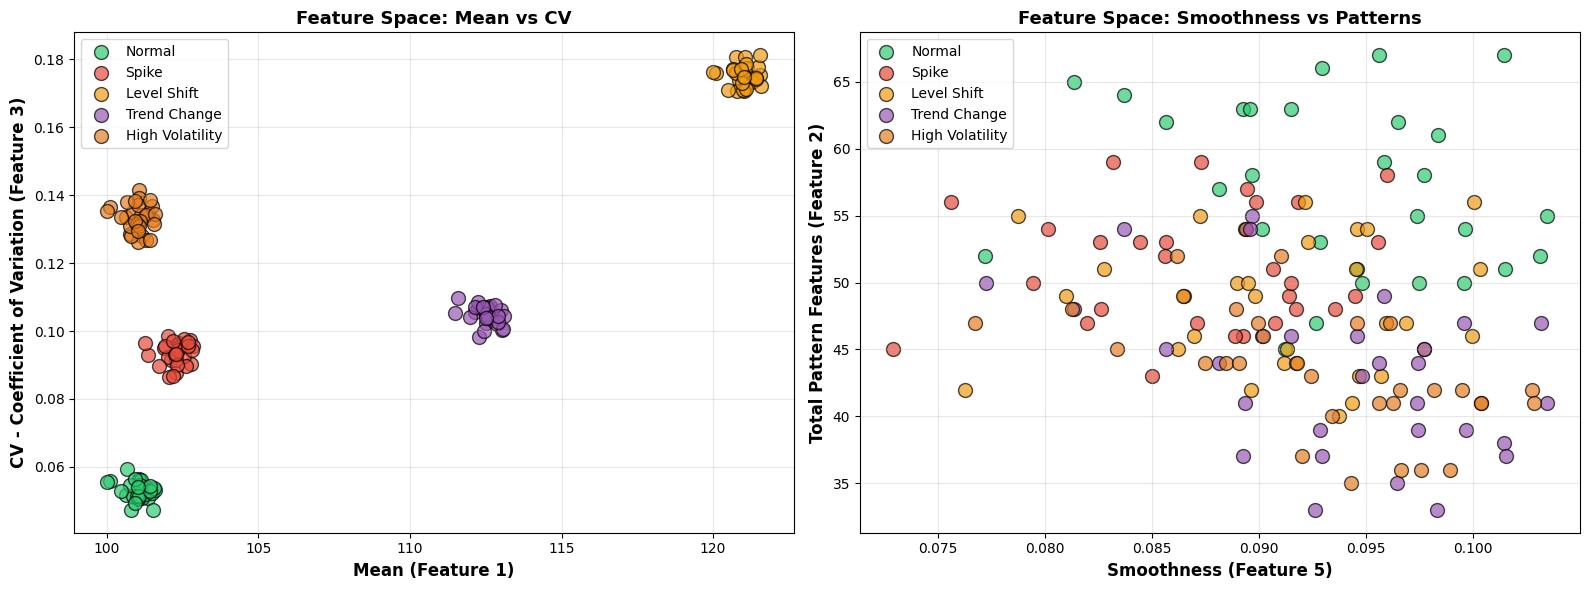


✓ 在特征空间中，正常样本和异常样本明显分离
✓ 不同异常类型占据不同区域


In [9]:
fig,axes=plt.subplots(1,2,figsize=(16,6))
colors={'Normal':'#2ecc71','Spike':'#e74c3c','Level Shift':'#f39c12','Trend Change':'#9b59b6','High Volatility':'#e67e22'}
# Plot 1: Mean vs CV
ax=axes[0]
for t in type_order:
    subset=df[df['type']==t]
    ax.scatter(subset['mean'],subset['cv'],label=t,alpha=0.7,s=100,c=colors[t],edgecolors='black',linewidth=1)
ax.set_xlabel('Mean (Feature 1)',fontsize=12,fontweight='bold')
ax.set_ylabel('CV - Coefficient of Variation (Feature 3)',fontsize=12,fontweight='bold')
ax.set_title('Feature Space: Mean vs CV',fontsize=13,fontweight='bold')
ax.legend(loc='best',fontsize=10)
ax.grid(True,alpha=0.3)
# Plot 2: Smoothness vs Total Patterns
ax=axes[1]
for t in type_order:
    subset=df[df['type']==t]
    ax.scatter(subset['smoothness'],subset['total_patterns'],label=t,alpha=0.7,s=100,c=colors[t],edgecolors='black',linewidth=1)
ax.set_xlabel('Smoothness (Feature 5)',fontsize=12,fontweight='bold')
ax.set_ylabel('Total Pattern Features (Feature 2)',fontsize=12,fontweight='bold')
ax.set_title('Feature Space: Smoothness vs Patterns',fontsize=13,fontweight='bold')
ax.legend(loc='best',fontsize=10)
ax.grid(True,alpha=0.3)
plt.tight_layout()
plt.show()
print('\n✓ 在特征空间中，正常样本和异常样本明显分离')
print('✓ 不同异常类型占据不同区域')